# ML Pipeline Orchestration

There are several tools available for orchestrating an ML pipeline. [Airflow](https://airflow.apache.org/) is very popular, and is a powerful general purpose tool, and better than a simple scheduler, but may not be the best choice for ML pipelines. [Prefect](https://www.prefect.io/) is a popular alternative to look into as well. For this session, we will be looking at [Metaflow](https://metaflow.org/), an open source tool created at Netflix specifically to make it easier for non-engineering data scientists to create workflows.

Note that Metaflow also does experiment tracking, similar to MLFlow. Also note that Metaflow is in active development, and is therefore more likely to have bugs, or changes, but they do have an active [Slack channel](http://slack.outerbounds.co/).

The *problem* with orchestration engines is that they are complex, and we can easily spend many weeks learning how to use just one of these tools, and then there is no guarantee that the company you end up working at will be using the same tool. Because of this, we will only scratch the surface of Metaflow in order to understand and appreciate the idea of setting up *flows* for our work, without getting too bogged down in all of the details of scaling up and out. Let's keep it simple and save the struggle for when you're actually getting paid to wrestle with technology.



## Metaflow Basics

First, we can install Metaflow and check that it gets installed properly:

`pip install metaflow`  
`metaflow`  
`metaflow --help`   

We should add this to our requirements.txt file.

We can define a flow (DAG) as a class which will be derived from metaflow's `FlowSpec` class, and we can define a step (node) of that flow as a method of our class (which we can name whatever we want), which will be annotated with the `@step` decorator. Here's a quick example:

```
from metaflow import FlowSpec, step

class HelloWorldFlow(FlowSpec):
    @step
    def start(self):
        """Starting point"""
        print("This is start step")
        self.next(self.hello)

    @step
    def hello(self):
        """Say hi"""
        print("Hello World!")
        self.next(self.end)

    @step
    def end(self):
         """Finish line"""
         print("This is end step")

if __name__ == '__main__':
     HelloWorldFlow()
```

Let's pick this apart. We created our own flow, which we called `HelloWorldFlow`, as a subclass of `FlowSpec`. Our flow has three steps denoted by the `@step` decorator. We explicitly define a `start` and `end` step. Note that the first step must be called `start` and the last step must be called `end`. We define the edges of our DAG, how one step flows to the next, by calling `next(step_name)` where `step_name` is the next step/node in the flow/DAG. We can only have one flow in a single python file, and we instantiate the flow using `if __name__ == '__main__':` so that it runs if we call the file as a script. We can save all of this into a python file called `helloworld.py` and then run:

`python helloworld.py`

Metaflow will not run the flow, it will simply check that the DAG is valid, and will run a linter to check our code. We will need to `pip install pylint` for this to work. We should see that the DAG is good and that pylint is happy. Let's go back and make the DAG invalid and rerun the code to see what happens. 

We can see a representation of the DAG by running 

`python helloworld.py show`

After verifying the DAG is what we want, we can run the flow:

`python helloworld.py run`

This will run the flow and we will see lines of output like this:

`2023-03-09 13:01:19.142 [1678395679097777/start/1 (pid 86303)] Task is starting.`

These lines contain a

- timestamp: 2023-03-09 13:01:19.142  
- run ID: 1678395679097777  
- step name: start  
- task ID: 1  
- process ID: pid 86303  
- log message: Task is starting.

All of these IDs help us track our experiments. Each run of the flow gets a unique run ID, and each task is processed separately and gets their own process ID. The combination of a run ID, step name, and task ID defines a *pathspec* which uniquely identifies a task and might come in handy later.



### Data flow

When processing data we need to be cognizant of how our workflow will access input data, and how that data will flow through the workflow. Commonly, in data science workflows, we would like to persist a state between steps in the workflow, meaning that we don't want each step of the workflow to be independent of others steps, we want to transfer the state of each step to the next step in the workflow. 

Recall that in Jupyter we can run code cells out of order, which means that unexpected things may change. Defining a workflow helps to alleviate that issue, and ensures that code is run in a specific order, and that variables that were defined in a previous step will persist to subsequent steps. With Metaflow we can persist states by using a common data store, which is managed internally by Metaflow. 

Persisting data is as simple as creating *instance* variables, which means, all we have to do is assign any variables or data that we want to persist to `self`. Anything assigned to `self` is also called an *artifact*, and these artifacts can be any python object (scalar, model, dataframe, etc.).

It is important to persist states in this way because each task in the workflow is executed separately, which may happen on different physical CPUs. Here's an example of persisting state:

```
from metaflow import FlowSpec, step

class Counterflow(FlowSpec):
    @step
    def start(self):
        self.count = 0
        self.next(self.add)

    @step
    def add(self):
        print("The count is", self.count, "before incrementing")
        self.count += 1
        self.next(self.end)

    @step
    def end(self):
        self.count += 1
        print("Final count is", self.count)

if __name__ == '__main__':
    Counterflow()
```

After running the above we can check logs or variables for a specific task using either the `logs` or `dump` command.

`python counterflow.py dump 1678397687773439/end/3`  
`python counterflow.py logs 1678397687773439/end/3`

What we should see, if we run `dump` or `logs` on the `end` task is that count = 2.



### Parameters

We can create parameters for our flows so that we can run the same flow with different values of those parameters. For example, if we define a model training flow for a random forest, we may want to create a parameter for the number of trees, or the number of features we sample for each node split. Then, when we run the flow, we can pass the parameter values that we want to use. 

Defining parameters in a flow is as simple as:

```
from metaflow import FlowSpec, step, Parameter

class Counterflow(FlowSpec):

    begin_count = Parameter('ct', default = 20, type = int, required = True)

    @step
    def start(self):
        self.count = self.begin_count
        self.next(self.add)

    ...

```

All arguments to `Parameter` are optional arguments, and default to `None`. 

- `help`: a line of help text  
- `required`: is this parameter required?  
- `default`: what is the default value?  
- `type`: what is the type? Can be `str, float, int, bool`.

If we saved the above (with the rest of the code from counterflow.py), we can run the flow, with a parameter value, like this:

`python counterflow.py run --ct 50`

Notice, the parameter name is `ct`, and we assigned it to a variable called `begin_count` in the script. We could've simply named these the same thing if we wanted to keep things simple.



### Branching and Merging 

For DAGs that are more complex than linear, such as nodes that flow to, or flow from, more than one node, we can define these in Metaflow easily.

In the case of branching, where a node flows into more than one node, we can simply include all of the nodes in the `next` method:

`self.next(self.one, self.two)` means that after the current step is run, steps `one` and `two` will run next, independently. Note that if there is any branching in our flow, we must do a merge at some point, before we reach the end of the flow. To do so, we can define a new step called `join` that will define how to merge the steps, like so:

`@step`
`def join(self, inputs):`

Note that we have an extra argument, called `inputs`, in a join step. Let's look at an example.

```
from metaflow import FlowSpec, step

class CounterBranchFlow(FlowSpec):
    @step
    def start(self):
        self.creature = "dog"
        self.count = 0
        self.next(self.add_one, self.add_two) # branching happens here

    @step
    def add_one(self):
        self.count += 1
        self.next(self.join) # move to the merging step, where the add_one and add_two nodes will merge

    @step
    def add_two(self):
        self.count += 2
        self.next(self.join) # move to the merging step, where the add_one and add_two nodes will merge

    @step 
    def join(self, inputs):
        self.count = max(inp.count for inp in inputs) # iterate over inputs to find max count
        print("count from add_one", inputs.add_one.count) # print specific values from named branch
        print("count from add_two", inputs.add_two.count) # print specific values from named branch

        self.creature = inputs[0].creature # creature was not modified, so we can use the index 0, and this step is required
        self.next(self.end)

    @step
    def end(self):
        print("The creature is", self.creature)
        print("The final count is", self.count)

if __name__ == '__main__':
    CounterBranchFlow()
```

When we run the above, we should notice that the process ID is different for `add_one` and `add_two`. This is because those two steps are executed separately, which will likely happen in parallel.

Merging can be complicated. What if we have a lot more artifacts to deal with? It is true that we **must** reassign **all** artifacts in the join step. Luckily, we can use `self.merge_artifacts(inputs)` to reassign all artifacts that we don't explicitly reassign. 

### foreach

Suppose instead of having static branches (a fully known DAG) we have dynamic branches, which means we have a DAG where we need to *fan out* a node into many nodes to do a single task in parallel, for example training a random forest model on different *folds* of the training data. To create these types of dynamic branches in Metaflow, we can do so by using the `foreach` argument in `next`.

```
from metaflow import FlowSpec, step

class ForeachFlow(FlowSpec):

    @step
    def start(self):
        self.creatures = ['bird', 'mouse', 'dog']
        self.next(self.analyze_creatures, foreach='creatures') # referring to our list of creatures, create a node (task) for each creature

    @step
    def analyze_creatures(self):
        print("Analyzing", self.input)
        self.creature = self.input
        self.score = len(self.creature)
        self.next(self.join)

    @step 
    def join(self, inputs):
        self.best = max(inputs, key=lambda x: x.score).creature # similar to argmax, this will return which input has maximum score
        self.next(self.end)

    @step
    def end(self):
        print(self.best, 'won!')

if __name__ == '__main__':
    ForeachFlow()
```

It is possible that we might get carried away, and accidentally run many, many processes in parallel. We can control the concurrency by setting the `max-num-splits` parameter. For example: 

`python foreach.py run --max-num-splits 100`

Or we can set an environmental variable: `export METAFLOW_RUN_MAX_NUM_SPLITS=100`.



## Example

Let's use our favorite wine dataset to demonstrate how we can use Metaflow for training a model. 

```
from metaflow import FlowSpec, step

class ClassifierTrainFlow(FlowSpec):

    @step
    def start(self):
        from sklearn import datasets
        from sklearn.model_selection import train_test_split

        X, y = datasets.load_wine(return_X_y=True)
        self.train_data, self.test_data, self.train_labels, self.test_labels = train_test_split(X,y, test_size=0.2, random_state=0)
        print("Data loaded successfully")
        self.next(self.end)

    @step
    def end(self):
        self.model = 'nothing_yet'
        print('done')

if __name__=='__main__':
    ClassifierTrainFlow()
```

We can save the above as `classifier_train_v1.py` and run it, and then confirm that data was loaded using the `dump` command:

`python classifier_train_v1.py dump 1678478123816769/start/1`

We should see that yes, some data is there, but we cannot see it because it is too large. In a notebook, we can inspect artifacts more easily. If we copy and paste the following into a notebook, we will be able to actually see the data.

```
from metaflow import Flow
run = Flow('ClassifierTrainFlow').latest_run
run['start'].task.data.train_data
```

From here, let's write a scoring script for getting predictions from our model (which has not yet been trained, but that's ok).

```
from metaflow import FlowSpec, step, Flow, Parameter, JSONType

class ClassifierPredictFlow(FlowSpec):
    vector = Parameter('vector', type=JSONType, required=True)

    @step
    def start(self):
        run = Flow('ClassifierTrainFlow').latest_run 
        self.train_run_id = run.pathspec 
        self.model = run['end'].task.data.model
        print("Input vector", self.vector)
        self.next(self.end)

    @step
    def end(self):
        print('Model', self.model)

if __name__=='__main__':
    ClassifierPredictFlow()
```

If we run the above flow and pass a vector to it, what should happen?

`python classifier_predict_v1.py run --vector '[1,2]'`

Now that we can verify that our two scripts are connected, we can worry about training the actual model, using the code below. Suppose we want to try a couple of different algorithms, kNN and SVM, we can do branching to train both in parallel, and then we can merge the results in a new step called `choose_model` where we pick the model with the best fit. We can also now integrate MLFlow to register our final model.

```
from metaflow import FlowSpec, step

class ClassifierTrainFlow(FlowSpec):

    @step
    def start(self):
        from sklearn import datasets
        from sklearn.model_selection import train_test_split

        X, y = datasets.load_wine(return_X_y=True)
        self.train_data, self.test_data, self.train_labels, self.test_labels = train_test_split(X,y, test_size=0.2, random_state=0)
        print("Data loaded successfully")
        self.next(self.train_knn, self.train_svm)

    @step
    def train_knn(self):
        from sklearn.neighbors import KNeighborsClassifier

        self.model = KNeighborsClassifier()
        self.model.fit(self.train_data, self.train_labels)
        self.next(self.choose_model)

    @step
    def train_svm(self):
        from sklearn import svm

        self.model = svm.SVC(kernel='poly')
        self.model.fit(self.train_data, self.train_labels)
        self.next(self.choose_model)

    @step
    def choose_model(self, inputs):
        import mlflow
        mlflow.set_tracking_uri('https://mlflow-test-run-275570243848.us-west2.run.app')
        mlflow.set_experiment('metaflow-experiment')

        def score(inp):
            return inp.model, inp.model.score(inp.test_data, inp.test_labels)

        self.results = sorted(map(score, inputs), key=lambda x: -x[1])
        self.model = self.results[0][0]
        with mlflow.start_run():
            mlflow.sklearn.log_model(self.model, artifact_path = 'metaflow_train', registered_model_name="metaflow-wine-model")
            mlflow.end_run()
        self.next(self.end)

    @step
    def end(self):
        print('Scores:')
        print('\n'.join('%s %f' % res for res in self.results))
        print('Model:', self.model)


if __name__=='__main__':
    ClassifierTrainFlow()
```

We can save the above as `classifier_train.py` and run it to see that it works. After confirming that it runs without error, we can modify our scoring script.

```
from metaflow import FlowSpec, step, Flow, Parameter, JSONType

class ClassifierPredictFlow(FlowSpec):
    vector = Parameter('vector', type=JSONType, required=True)

    @step
    def start(self):
        run = Flow('ClassifierTrainFlow').latest_run 
        self.train_run_id = run.pathspec 
        self.model = run['end'].task.data.model
        print("Input vector", self.vector)
        self.next(self.end)

    @step
    def end(self):
        print('Model', self.model)
        print('Predicted class', self.model.predict([self.vector])[0])

if __name__=='__main__':
    ClassifierPredictFlow()
```

Let's save the above as `classifier_predict.py`. To run it, we need to pass a vector of values so we can get a prediction from the model that we chose during our last run.

`python classifier_predict.py run --vector '[14.3,1.92,2.72,20.0,120.0,2.8,3.14,0.33,1.97,6.2,1.07,2.65,1280.0]'`

To fully examine the artifacts (the trained model), we can go into a notebook like before, and extract the fitted model from the last run.

```
from metaflow import Flow
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

run = Flow('ClassifierTrainFlow').latest_run
run

model, score = run.data.results[0]
test_data = run['start'].task.data.test_data
test_labels = run['start'].task.data.test_labels

predictions = model.predict(test_data)
cm = confusion_matrix(test_labels, predictions, labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
```

Let's take a second to appreciate what we just accomplished. We created a training pipeline that loads data, trains two models, and selects the best model. We then created a scoring pipeline that takes the best model from the training pipeline and scores a brand new unseen observation. Not too shabby!


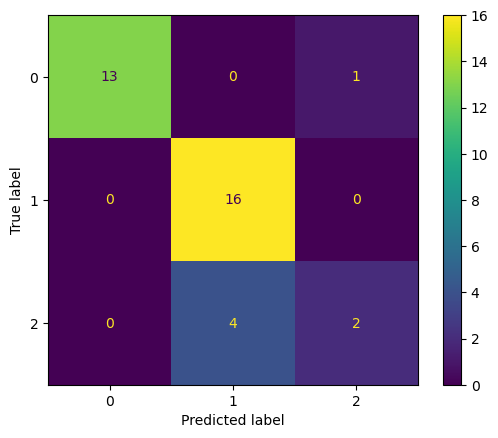

In [7]:
from metaflow import Flow
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

run = Flow('ClassifierTrainFlow').latest_run
run

model, score = run.data.results[0]
test_data = run['start'].task.data.test_data
test_labels = run['start'].task.data.test_labels

predictions = model.predict(test_data)
cm = confusion_matrix(test_labels, predictions, labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()


### What Next?

Our toy dataset example is a nice way to demonstrate flows, but it leaves a lot of questions unanswered, such as:

- What if our input data is very big?  
- What if we want to train 1000s of models?  
- Can we modularize our code?  
- How do we schedule flows to run instead of running them manually?  
- How can we test out a newer version of sklearn if our current in-production model uses an older version?

We will try to answer these questions a future lab.

# ML Workflows Lab

## Overview

Creating ML flows is necessary when moving models out of development notebooks and into production-ready code. There are many ways to do this, but creating DAGs, whether through a tool, or through a collection of scripts and shell scripts that run in a specific order, is the default. 

## Goal

The goal in this lab is to create two flows, one for training our model (using the same dataset we selected for the previous MLFlow labs), and one for model scoring (sometimes called inference), and run these flows locally. We will likely modify our training flow later when we move Metaflow to GCP, and our scoring flow later when we get to the model deployment section of the course. We will also integrate MLFlow model registration with our flow.

## Instructions

### Installation and Creating a Training Flow

1. Install Metaflow in your project environment and add it to the requirements.txt file.  
2. Use the `FlowSpec` class and the `@step` decorator to create a flow that will train your model on your local machine. You *might* have steps such as: ingest raw data; feature transformations; hyperparameter tuning; choose best model; and register and save model using the MLFlow model registry (*with MLFlow running locally for now*). You can modularize your code so that different steps can be in different flows, or more commonly so that different steps of the same flow can be imported from other modules. For example, data transformations can be written in a separate script and imported into a specific step in your flow like this:  

```
@step
def start(self):
    import dataprocessing
```  
    
3. Be sure to add parameters to your flow when it makes sense, for example, for cross-validation or setting seeds.  
4. Save your flow in the `src` folder as `trainingflow.py`. Run your training flow to register a new "best" model in MLFlow using the parameters from your previously registered "best" model.  

### Creating a Scoring FLow

5. Create a model scoring flow for making predictions from your registered model on new data. You *might* have steps such as: ingest new data; feature transformations; load the registered model; make predictions; and output predictions. Again, you may have separate scripts for each of these steps which can be imported into the steps of the flow. 
6. Save your flow in the `src` folder as `scoringflow.py`. Run your scoring flow on a set of data that was not used for model training, or simply save a hold-out set of data from the training set and use this to demonstrate your scoring flow.  

### Turning It In

Push your flows to Github. **Do not add the `.metaflow/` folder to git**. Submit the Github URL that goes directly to the `src` folder. Be sure to add comments to your scripts so that they are easy to read.

In [12]:
import pandas as pd
pd.read_csv("../data/heart_dataset.csv")

,Age,Gender,BloodPressure,Cholesterol,HeartRate,QuantumPatternFeature,HeartDisease
0,68,1,105,191,107,8.362241,1
1,58,0,97,249,89,9.249002,0
2,44,0,93,190,82,7.942542,1
3,72,1,93,183,101,6.495155,1
4,37,0,145,166,103,7.653900,1
...,...,...,...,...,...,...,...
495,34,0,126,292,116,9.303403,0
496,41,0,164,248,114,9.067889,0
497,45,1,159,175,75,8.718708,0
498,55,0,107,157,101,7.337650,1
